In [1]:
%pylab inline
import time
import scanpy
import pandas as pd
import seaborn as sns
sns.set_context('talk', font_scale=2)
from numpy import linalg as LA
from scipy.linalg import eigh

from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from scipy.io import loadmat

from sklearn.manifold import MDS
from sklearn.cluster import SpectralClustering

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
def simulate_uniform_2d(n, low1=-1, high1=1, low2=-2, high2=2):
    """
    
    Parameters
    ----------
    n: integer
       Number of points
       
    d: integer
       Number of dimensions
    """
    X1 = np.random.random((n, 1)) * (high1-low1) + low1
    X2 = np.random.random((n, 1)) * (high2-low2) + low2
    return np.hstack([X1, X2])



Populating the interactive namespace from numpy and matplotlib


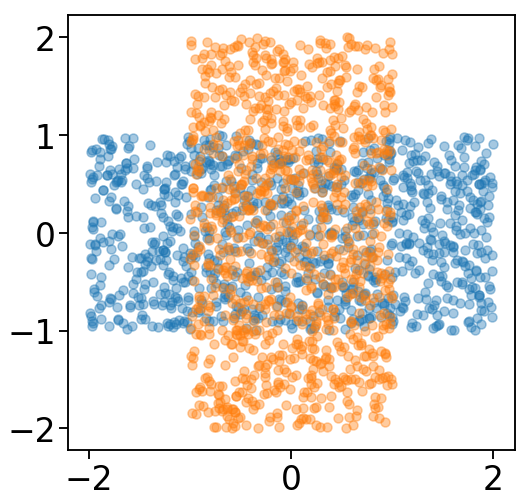

In [2]:
X1 = simulate_uniform_2d(1000, low1=-2, high1=2, low2=-1, high2=1)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X1[:,0], X1[:,1], alpha=0.4)
X2 = simulate_uniform_2d(1000, low1=-1, high1=1, low2=-2, high2=2)
ax.scatter(X2[:,0], X2[:,1], alpha=0.4)


X = np.vstack([X1, X2])

In [79]:
def do_clustering(X, d, radius):
    nbrs = NearestNeighbors(radius=radius, algorithm='ball_tree').fit(X)
    distances, X_neighbors = nbrs.radius_neighbors(X)
    point_indices_master = pd.Series(range(X.shape[0]))
    

    # Step 0. Pick point y1 from data. pick y2 from data not in the neighborhood of y1. Pick y3 not in neighborhood of y1 and y2
    # Keep doing till n0 centers are found
    y_n0_centers = []
    while len(point_indices_master)>0:
        y = np.random.choice(point_indices_master, 1)[0]
        y_n0_centers.append(y)
        # Generate neighbors
        y_neighbors = X_neighbors[y]
        y_neighbors = y_neighbors[y_neighbors!=y]
        # Drop picked center from being picked up ever later
        point_indices_master.drop(y, inplace=True)
        # Drop picked center's neighbors
        point_indices_master.drop(y_neighbors, inplace=True, errors='ignore')
    print('N_nets: {}'.format(len(y_n0_centers)))
    # Step 1 for each i=1..mo0, calculate the sample covariance matrix C1 of neirhborhood of yi
    covariances = []
    for center in y_n0_centers:
        cov = np.cov(X[X_neighbors[center]].T)
        covariances.append(cov)
    
    Q = []
    center_means = []
    for cov in covariances:
        
        #eig_values, eig_matrix = eigh(cov, eigvals=range(d))
        #Q.append(eig_matrix[:, :d])
        U,s,V = LA.svd(cov)
        Q.append(np.dot(U[:, :d], U[:, :d].T))
        
    for center in y_n0_centers:
        center_means.append(X[X_neighbors[center]].mean(axis=0))
    
    A = np.zeros((len(y_n0_centers), len(y_n0_centers)))
    B = np.zeros((len(y_n0_centers), len(y_n0_centers)))
    for i in range(len(y_n0_centers)):
        for j in range(len(y_n0_centers)):
            A[i, j] = LA.norm(center_means[i]-center_means[j], 2)
            #B[i, j] = LA.norm(covariances[i]-covariances[j], 2)
            B[i, j] = LA.norm(Q[i]-Q[j], 2)
            
    C = np.ones(A.shape)
    
    min_A = np.min(np.max(A+(10**3)* np.eye(A.shape[0])))
    max_A = np.max(np.max(A))
    
    
    
    
    min_B = np.min(np.max(B+(10**3)* np.eye(B.shape[0])))
    max_B = np.max(np.max(B))
    
    step_A = (np.log(max_A) - np.log(min_A))/10
    step_B = (np.log(max_B) - np.log(min_B))/10
    
    
    sigma_A = np.exp(np.arange(-10, 10, 1)*step_A + np.log(min_A))
    sigma_B = np.exp(np.arange(-2,10, 0.4)*step_B + np.log(min_B))
    
    connected_A = np.max(np.min(A+100*np.eye(A.shape[0])))
    
    #connected_graph = A<connected_A
    #connected_graph = connected_graph - np.diag(np.diag(connected_graph))
    
    eta = 1
    
    
    print(len(sigma_A))
    print(len(sigma_B))
        
    W = np.zeros((len(y_n0_centers), len(y_n0_centers)))
    for i in range(W.shape[0]):
        for j in range(W.shape[0]):
            #projection_i =  np.dot(X_neighbors[y_n0_centers[i]], Q[i])
            #projection_j =  np.dot(X_neighbors[y_n0_centers[j]], Q[j])
            #W[i, j] = np.exp(-LA.norm(X[y_n0_centers[i]]-X[y_n0_centers[j]], 2)**2/epsilon**2) * np.exp(-LA.norm(projection_i-projection_j, 2)**2/eta**2)
            W = np.exp(-np.power(A, 2)/sigma_A[i]**2) * np.exp(-np.power(B, 2)/sigma_B[j]**2)
            print(W.shape)
            clustering = SpectralClustering(n_clusters=2,
                                            assign_labels="kmeans",
                                            affinity='precomputed',
                                            random_state=0).fit(W)


            centers = X[y_n0_centers]

            # For each point, calculate the distance from all 4 vectors and find the minimum
            distances = euclidean_distances(X, centers)
            min_distance_centers = np.argmin(distances, axis=1)
            color_indices = pd.Series(clustering.labels_)[min_distance_centers]
            colors = pd.Series(sns.color_palette('Paired'))
            fig, ax = plt.subplots(figsize=(8, 8))

            ax.scatter(X[:,0], X[:,1], alpha=0.4, color=colors[color_indices])
            for center in y_n0_centers:
                ax.scatter(X[center, 0], X[center, 1], color='green', s=120)

In [80]:
Y.shape

(1202, 2)

N_nets: 43
20
30
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)
(43, 43)


IndexError: index 30 is out of bounds for axis 0 with size 30

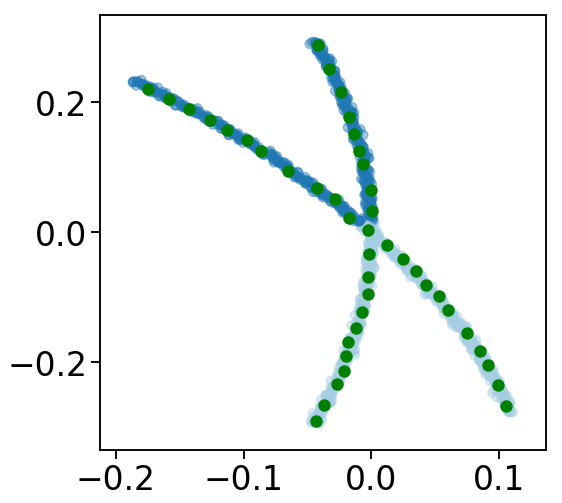

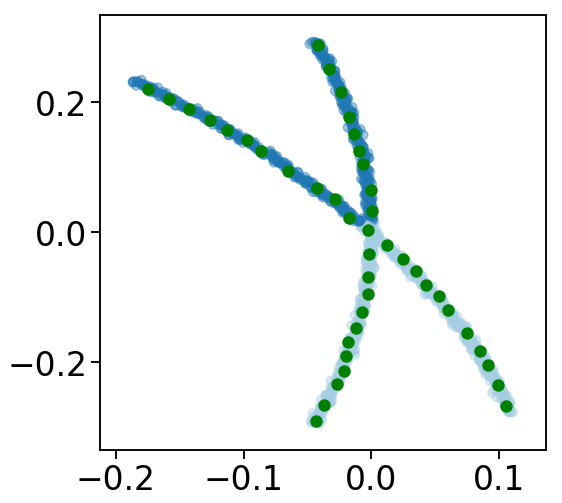

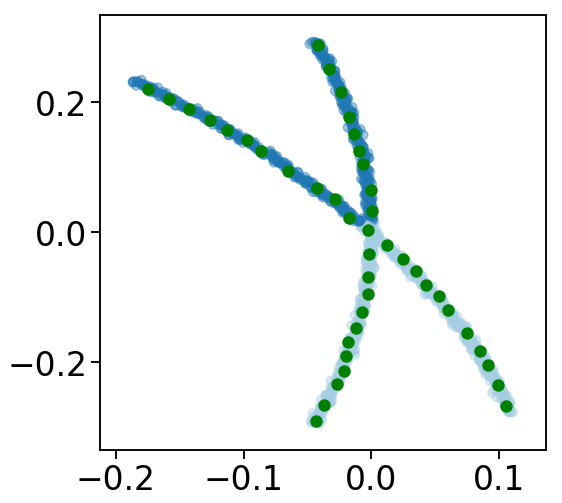

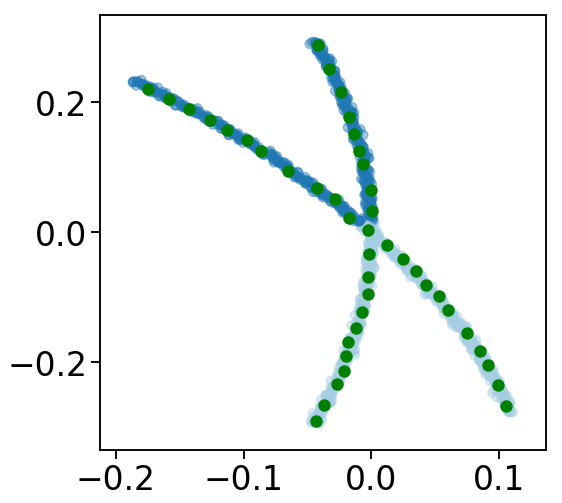

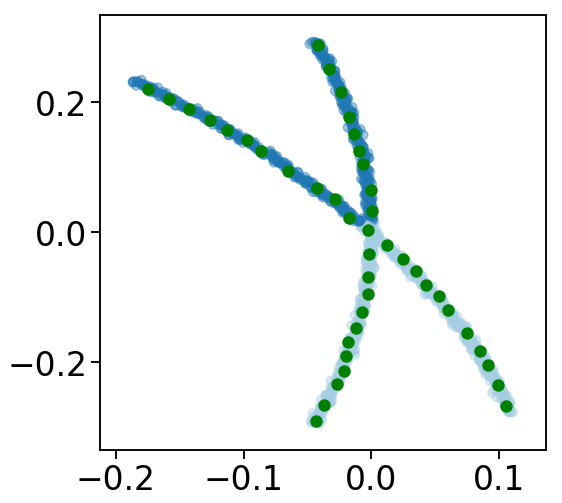

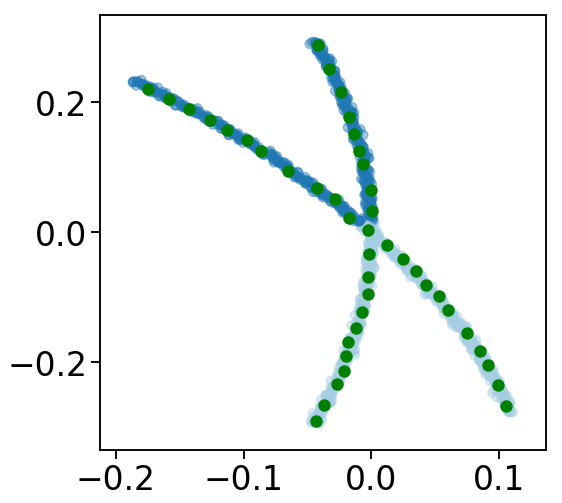

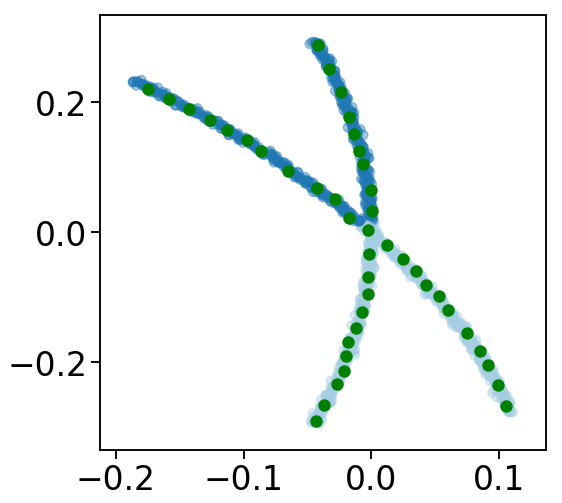

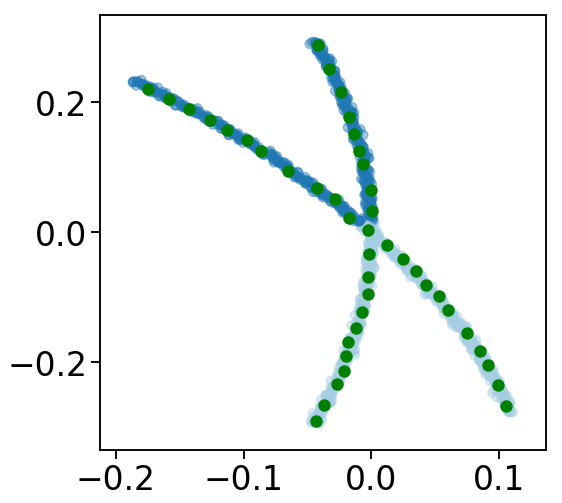

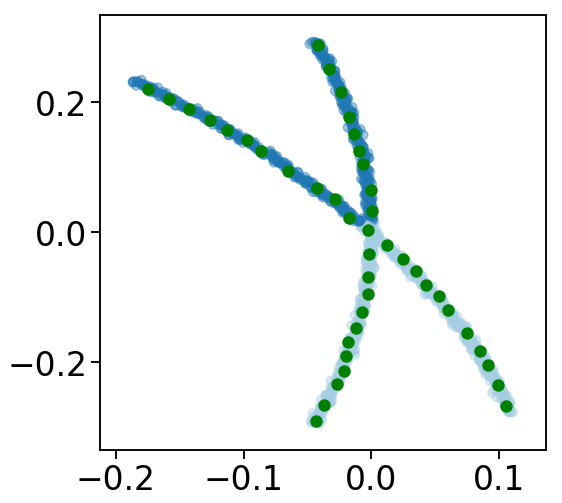

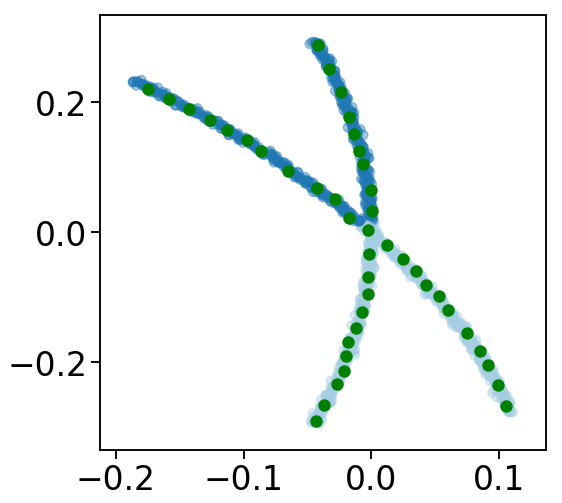

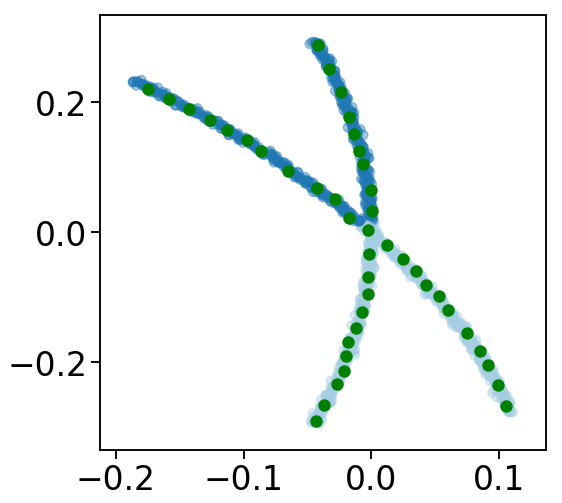

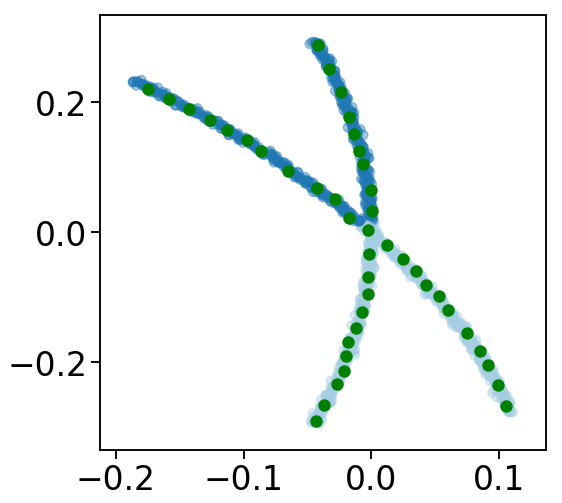

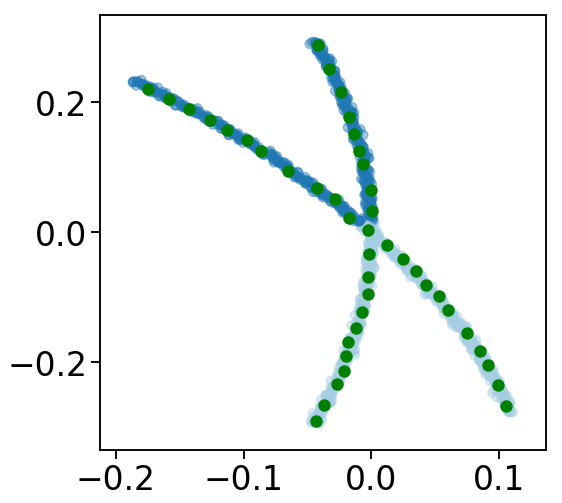

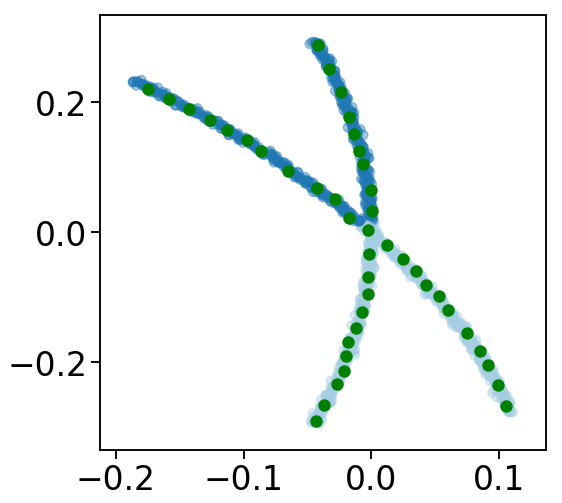

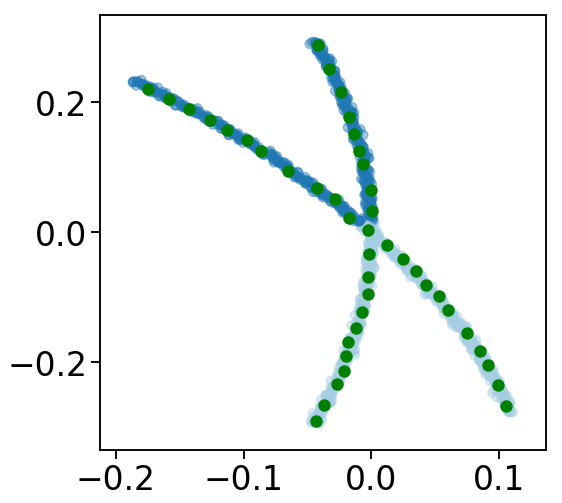

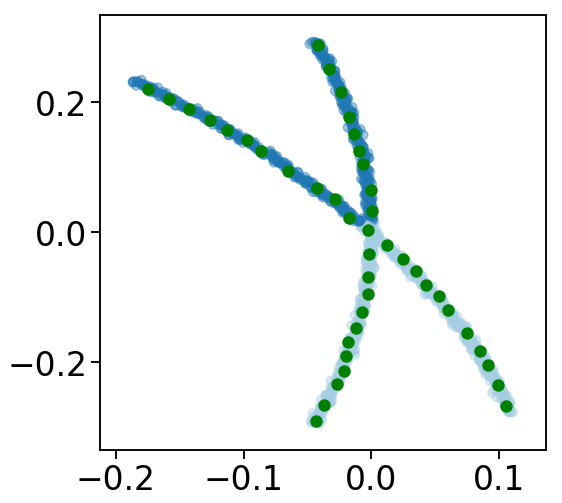

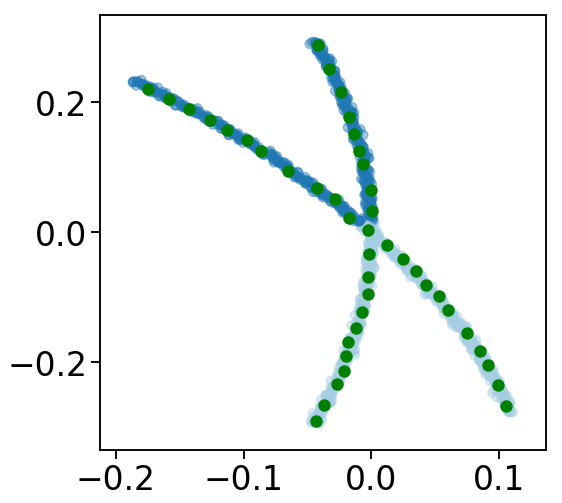

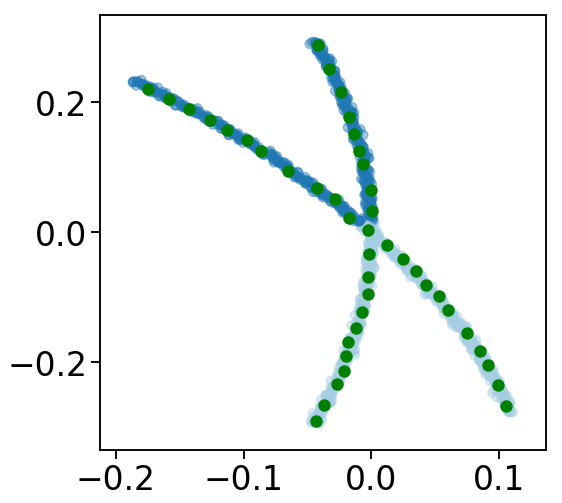

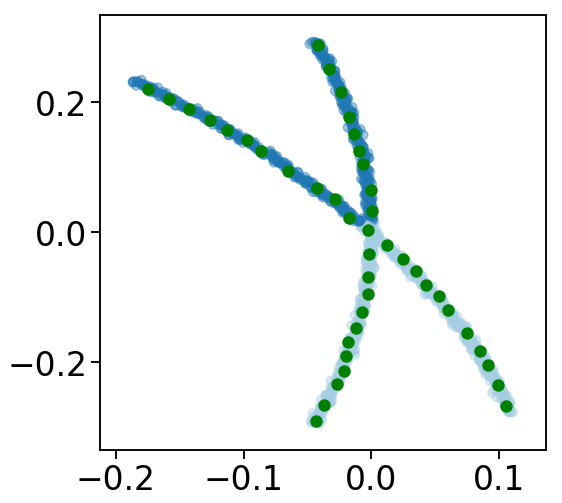

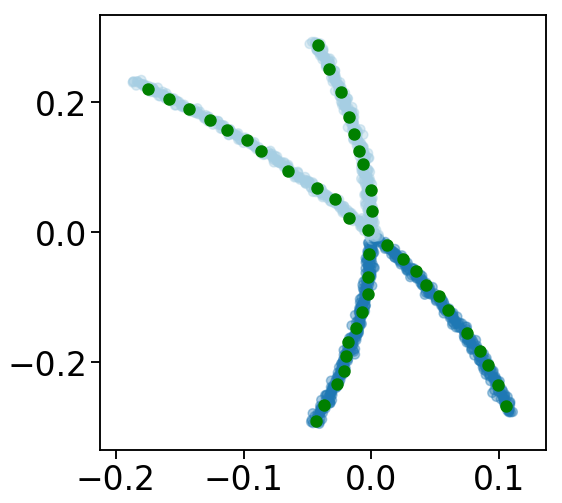

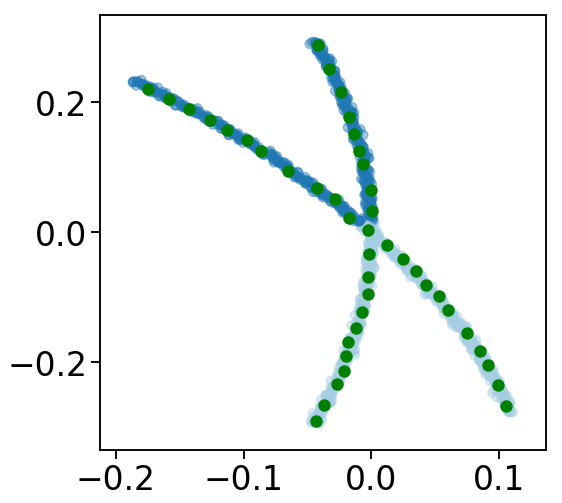

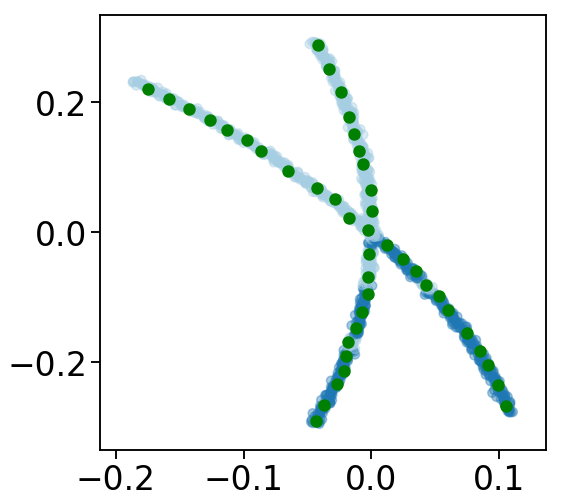

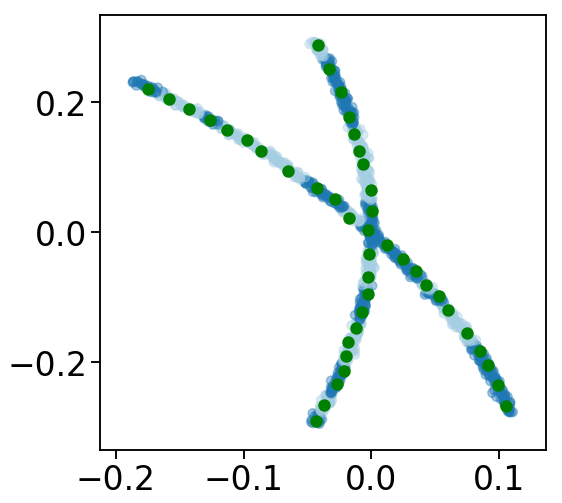

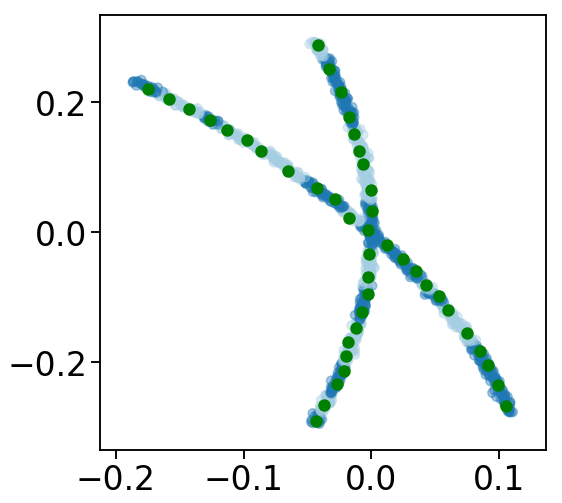

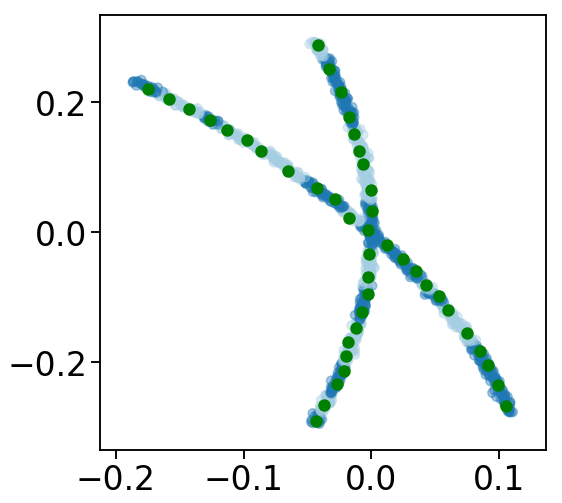

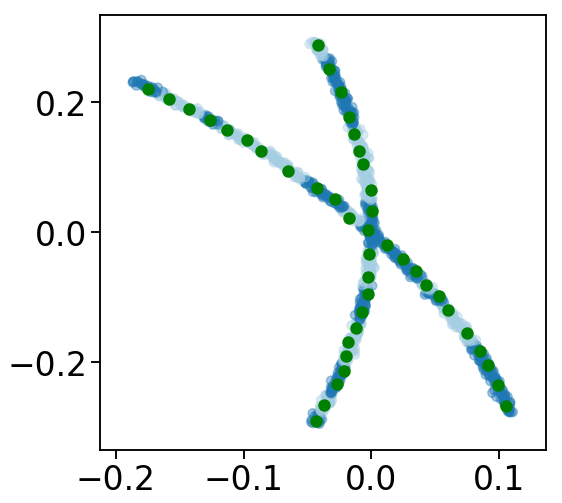

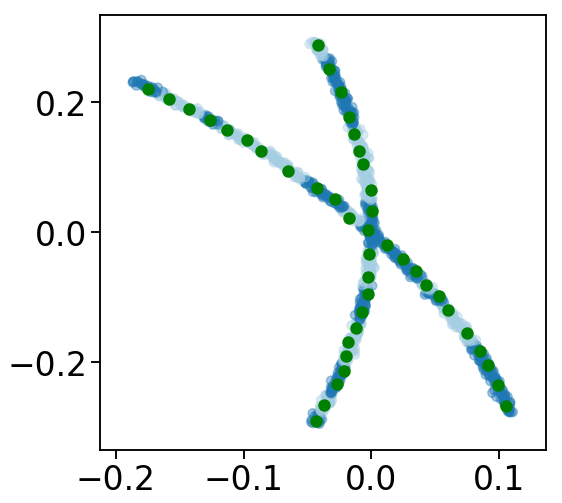

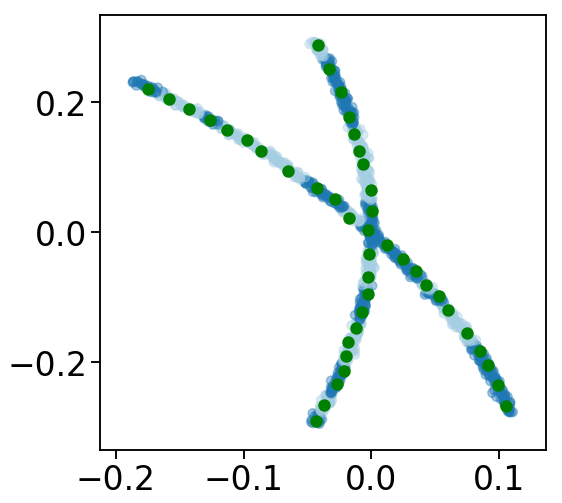

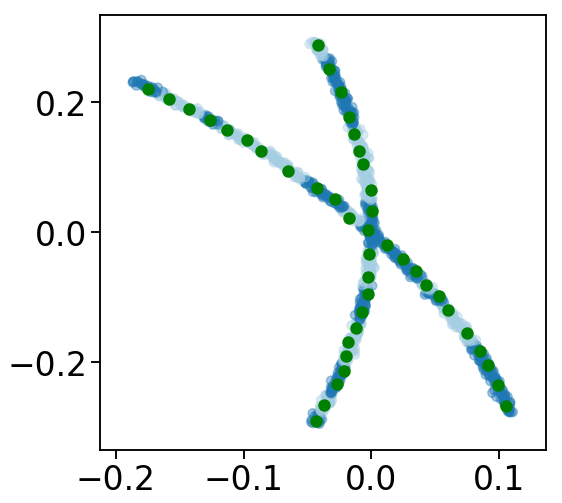

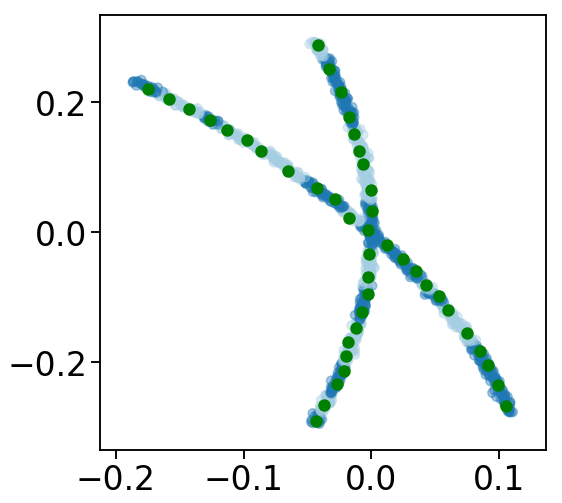

In [81]:
d = 2
radius = 0.02
eta = 1
epsilon = 1
do_clustering(Y, d, radius)

In [24]:
X.shape

(2000, 2)

In [47]:
d = 2
radius = 0.02
eta = 1
epsilon = 1
do_clustering(X, d, radius)

N_nets: 1798


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyboardInterrupt: 

In [17]:
data = loadmat('../local-pca-code-matlab/twocurves2.mat')

In [18]:
Y = data['Y']

N_nets: 43


ValueError: operands could not be broadcast together with shapes (39,2) (2,39) 

In [11]:
Y

(1202, 2)